### Imports and CUDA

In [61]:
# !pip uninstall -y typing_extensions
# !pip install typing_extensions==4.11.0
# !pip uninstall wandb -y
# !pip install wandb
# !pip install matplotlib
# !pip install scikit-learn
# !pip install pandas

In [62]:
# Matplotlib
import requests
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn

import pandas as pd
from tqdm import tqdm
import wandb
import os

In [63]:
# Login to Wandb for logging

# wandb.login()

In [64]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Objective

#### To develop a model that predicts taxi availability within a specific area for the next three hours. This means that if the model is run at 12 PM, it will provide predicted taxi availability for 1 PM, 2 PM, and 3 PM.

The area of interest is defined by the following geographical boundaries:

    North: 1.35106
    South: 1.32206
    East: 103.97839
    West: 103.92805

To identify the taxis currently available within this region, we use the TaxiAvailabilityScript.py.

This script collects real-time data, which serves as input for our predictive model.

By leveraging historical taxi availability trends and real-time data, our model aims to provide accurate forecasts, helping commuters, ride-hailing services, and urban planners make informed decisions.


# **To-Do List for Taxi Availability Prediction**

## **Step 1: Cleaning the Taxi Availability Data**
The first step involves retrieving and preprocessing the taxi availability dataset. The dataset consists of the following columns:

1. **DateTime**  
2. **Taxi Available Throughout Singapore**  
3. **Taxi Available in Selected Box Area**  
4. **Coordinates[]**  

For our specific use case, **the coordinates column will not be used for now**.  

To prepare the data for the neural network:  
- **Inputs:** We will use `DateTime` and `Taxi Available Throughout Singapore` as features.  
- **Output:** `Taxi Available in Selected Box Area` will be the target variable.  
- **DateTime Conversion:** Since `DateTime` is not in a format suitable for neural networks, we will extract relevant features:
  - **IsWeekend**: A binary feature (1 if it's a weekend, 0 otherwise).  
  - **Hour**: Transformed into a numerical value between **1 and 24** (avoiding 0, which may cause training issues).  

---

## **Step 2: Adding Additional Features**  
*(Partially completed; will be refined over time)*  

Aside from the existing columns, we aim to incorporate additional features that may improve prediction accuracy:  

1. **ERP Rates (Electronic Road Pricing) at the given time and location**  
   - Uncertain if this will significantly impact predictions. Further analysis is needed.  

2. **Number of LTA (Land Transport Authority) gantry locations**  
   - Again, its usefulness remains uncertain—further evaluation required.  

3. **Traffic Incidents in the Selected Area**  
   - A script (`TrafficIncidentScript.py`) has been written to update `traffic_incident.csv` with the latest traffic incidents.  
   - Over time, as the dataset grows, we hope this feature will become useful.  

4. **Number of Taxi Stands in the Area**  
   - Currently **not useful** because our area of interest is fixed.  
   - However, if we allow dynamic selection of areas in the future, this could become relevant.  

5. **Temperature at a Given Time and Date** *(To be implemented)*  

6. **Rainfall Data** *(To be implemented)*  

To ensure all features align properly, we will **synchronize all datasets based on DateTime** before feeding them into the model.  

---

## **Step 3: Creating the Training-Test Split**  
- Initially, we will perform an **80/20 Training-Test split** for simplicity.  
- In the future, we may introduce a **Training-Validation-Test split** to further refine model performance.  

---

## **Step 4: Building the Model**  
We will begin with an **LSTM model**, as LSTMs are well-suited for time-series forecasting.  
- **Initial Limitation:** The model, in its basic form, will only predict the next hour.  
- **Future Improvement:** A **sliding window approach** will be explored and implemented to extend predictions further.  

---

## **Step 5: Model Evaluation and Improvement**  
- After the initial model is trained, we will assess its performance.  
- Based on results, we will explore potential improvements, such as hyperparameter tuning, architectural modifications, or additional feature engineering.  

---

This structured approach will guide the development of a robust and accurate taxi availability prediction model. 🚖💡


## **Preparing the taxi_availability data here.**

Normalization of certain inputs are done as well, but I am unsure if it is the right thing to do as well.

In [65]:
merged_weather_taxi_df = "merged_file_with_mean.csv"
taxi_df = pd.read_csv(merged_weather_taxi_df, delimiter = ",")

#Adjusting for weather parameters
taxi_df = taxi_df.drop(columns = "stationId")

#Adjusting for taxi_vailability parameters
taxi_df_coordinates = taxi_df["Coordinates[]"]
taxt_df_datetime = taxi_df["DateTime"]
taxi_df = taxi_df.drop(columns = "Coordinates[]")
taxi_df = taxi_df.drop(columns = "Taxi Available in Selected Box Area")
taxi_df["DateTime"] = pd.to_datetime(taxi_df["DateTime"])

taxi_df["IsWeekend"] = (taxi_df["DateTime"].dt.weekday >= 5).astype(int)
taxi_df["Hour"] = taxi_df["DateTime"].dt.hour + 1  # Convert 0-23 to 1-24
taxi_df = taxi_df.drop(columns = "DateTime")

print(taxi_df.dtypes)

Taxi Available throughout SG      int64
temp_value                      float64
humidity_value                  float64
rainfall_value                  float64
peak_period                       int64
Group                             int64
Average Taxi Availability       float64
IsWeekend                         int64
Hour                              int32
dtype: object


### Converting all dtypes into float32

In [66]:
# taxi_df=taxi_df[:5120]
numeric_columns = taxi_df.select_dtypes(include=['int64', 'int32','float64','object']).columns
print("numeric_columns",numeric_columns)
taxi_df[numeric_columns] = taxi_df[numeric_columns].astype('float32')
numeric_columns = taxi_df.select_dtypes(include=['int64', 'int32','float64','object']).columns

# Convert selected columns to float32
taxi_df[numeric_columns] = taxi_df[numeric_columns].astype('float32')

numeric_columns Index(['Taxi Available throughout SG', 'temp_value', 'humidity_value',
       'rainfall_value', 'peak_period', 'Group', 'Average Taxi Availability',
       'IsWeekend', 'Hour'],
      dtype='object')


### Normalizing all values

In [67]:
# #---------------Normalise-----------------------
# Drop 'DateTime' as it's no longer needed
# Normalize the 'Hour' and 'IsWeekend' columns (if needed)

data_min = taxi_df.min(axis=0)
data_max = taxi_df.max(axis=0)
taxi_df_normalized = (taxi_df - data_min) / (data_max - data_min)

# scaler = MinMaxScaler()
# taxi_df[["Hour", "IsWeekend", "Taxi Available throughout SG","Taxi Available in Selected Box Area"]] = scaler.fit_transform(taxi_df[["Hour", "IsWeekend","Taxi Available throughout SG","Taxi Available in Selected Box Area"]])
# taxi_df = taxi_df.apply(pd.to_numeric, errors='coerce')
taxi_df_output_normalized  = taxi_df_normalized["Average Taxi Availability"]
taxi_df_output_training_normalized = taxi_df_normalized["Average Taxi Availability"]
taxi_df_normalized = taxi_df_normalized.drop(columns = "Average Taxi Availability")
taxi_df_normalized = taxi_df_normalized.drop(columns = "Group")

taxi_df_normalized.to_csv("checker.csv", index=False)  # Set index=False to exclude row numbers

# Convert to NumPy arrays
input_data = taxi_df_normalized.values  # Shape: (5120, num_features)
output_data = taxi_df_output_normalized.values  # Shape: (5120,)
output_training_data = taxi_df_output_training_normalized.values
# taxi_df_output = taxi_df["Taxi Available in Selected Box Area"]
# input_data = taxi_df.values  # Shape: (5120, num_features)
# output_data = taxi_df_output.values  # Shape: (5120,)

print("Input Data: ",input_data.shape)
print("Output Data: ",output_data.shape)
print("Training Output Data: ", output_training_data.shape)

# Define sequence length

Input Data:  (25591, 7)
Output Data:  (25591,)
Training Output Data:  (25591,)


### No Normalization Style

In [68]:
# # #---------------No Normalization-----------------------

# # # Drop 'DateTime' as it's no longer needed
# taxi_df_no_norm = taxi_df  # Remove DateTime but keep raw values

# # Separate input and output data
# taxi_df_output_no_norm = taxi_df_no_norm["Taxi Available in Selected Box Area"]
# taxi_df_no_norm = taxi_df_no_norm.drop(columns=["Taxi Available throughout SG"])
# taxi_df_output_for_teacher_forcing = taxi_df_no_norm

# # Save to CSV for checking
# taxi_df_no_norm.to_csv("checker_no_norm.csv", index=False)  # Set index=False to exclude row numbers

# # Convert to NumPy arrays (raw values)
# input_data = taxi_df_no_norm.values  # Shape: (5120, num_features)
# output_data = taxi_df_output_no_norm.values  # Shape: (5120,)
# output_data_for_teacherforcing = taxi_df_output_for_teacher_forcing.values

# print("Input Data: ", input_data.shape)
# print("Input Data: ", input_data[0])

# print("Output Data: ", output_data.shape)
# print("Output Data: ", output_data[0])

# print("Output Data for Teacher Forcing: ", output_data_for_teacherforcing.shape)
# print("Output Data for Teacher Forcing: ", output_data_for_teacherforcing[0])

### Create Sequence Function

In [69]:
seq_length = 24
pred_horizon = 3  # Number of future time steps to predict

def create_sequences(data, labels, seq_length, pred_horizon):
    xs, ys = [], []
    for i in range(0, len(data), seq_length):  # Start from 0 and increment by seq_length
        if i + seq_length + pred_horizon <= len(data):  # Ensure enough data for prediction horizon
            xs.append(data[i:i + seq_length])  # Input sequence (continuous)
            ys.append(labels[i + seq_length : i + seq_length + pred_horizon])  # Next 3 values
    return np.array(xs), np.array(ys)

In [70]:

# X, y = create_sequences(input_data, output_data, seq_length,pred_horizon)
X, y = create_sequences(input_data, output_training_data, seq_length,pred_horizon)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y[:, None], dtype=torch.float32)
y = y.permute(0, 2, 1)  # Shape: (samples, pred_horizon, 1)

# Split sizes
total_samples = len(X)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

# Split the data
trainX, valX, testX = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
trainY, valY, testY = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Create TensorDatasets
train_dataset = TensorDataset(trainX, trainY)
val_dataset = TensorDataset(valX, valY)
test_dataset = TensorDataset(testX, testY)

# DataLoaders
batch_size = 17
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Example of accessing a batch of data
for inputs, targets in train_loader:
    print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')
    break  # Only print the first batch for verification

Inputs: torch.Size([17, 24, 7]), Targets: torch.Size([17, 3, 1])


In [71]:
print("test_loader",len(test_loader))

test_loader 6


tensor([0.5126, 0.6026, 0.6405, 0.7149, 0.6505, 0.3931, 0.4699, 0.5000, 0.5083,
        0.5454, 0.4191, 0.5330, 0.6056, 0.6674, 0.6421, 0.6480, 0.4863, 0.3987,
        0.4301, 0.4492, 0.4465, 0.4635, 0.5226, 0.4326])
tensor([0.3378, 0.3680, 0.3789])
torch.Size([24]) torch.Size([3])


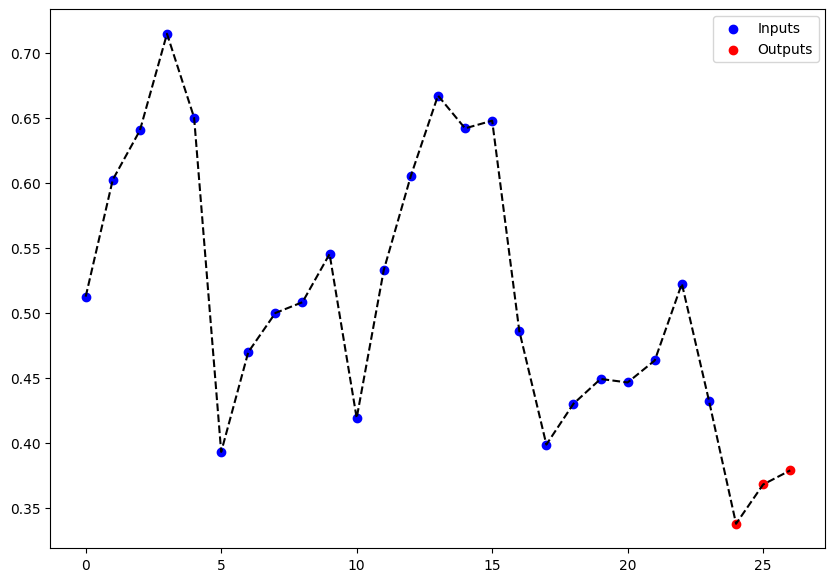

In [72]:
# Testing our dataset object and visualizing data
def visualize_samples(inputs, outputs):
    plt.figure(figsize = (10, 7))
    inputs = inputs.cpu().numpy()
    outputs = outputs.cpu().numpy()
    times1 = [i for i in range(len(inputs))]
    times3 = [len(inputs) + i for i in range(len(outputs))]
    plt.scatter(times1, inputs, label = "Inputs", c = "b")
    plt.scatter(times3, outputs, label = "Outputs", c = "r")
    plt.plot(times1 + times3, np.hstack([inputs, outputs]),  "k--")
    plt.legend(loc = "best")
    plt.show()

t = 0
inputs, outputs = train_dataset[t]
print(inputs[:,0])
print(outputs[:,0])
print(inputs[:, 0].shape, outputs[:, 0].shape)
visualize_samples(inputs[:, 0], outputs[:, 0])

Using a bidirectional LSTM as the encoder

In [73]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        # print("Encoder's input size: ", input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

    def forward(self, inputs):
        # Passing the input sequence through the LSTM
        
        output, (hidden, cell) = self.lstm(inputs)
        # print("encoder output size: ", output.shape)

        return hidden, cell

In [ ]:
class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.3):
        super(DecoderLSTM, self).__init__()


        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        # Implementing Prof Idea
        self.linear1 = nn.Linear(hidden_size, 1)
        self.linearsub1 = nn.Linear(hidden_size, input_size)

        self.linear2 = nn.Linear(hidden_size, 1)
        self.linearsub2 = nn.Linear(hidden_size, input_size)

        self.dropout = nn.Dropout(p=dropout_rate)


    def forward(self, x, hidden,target=None):
        outputs = []
        decoder_input = x
        
        # First LSTM layer
        y1, hidden1 = self.lstm(decoder_input, hidden)
        y1 = self.dropout(y1)
        linear_y1 = self.linear1(y1)
        linear_y1 = linear_y1.mean(dim=1, keepdim=True)
        linear_suby1 = self.linearsub1(y1)

        # if target is not None:
        #     # use ground truth from target instead of prediction
        #     linear_suby1 = torch.zeros_like(linear_suby1)
        #     linear_suby1[:, 0, 0] = target[:, 0, 0]  # use target value in 1st feature

        # Second LSTM layer
        y2, hidden2 = self.lstm(linear_suby1, hidden1)
        y2 = self.dropout(y2)
        linear_y2 = self.linear2(y2)
        linear_suby2 = self.linearsub1(y2)
        linear_y2 = linear_y2.mean(dim=1, keepdim=True)

        # if target is not None:
        #     # use ground truth from target instead of prediction
        #     linear_suby2 = torch.zeros_like(linear_suby2)
        #     linear_suby2[:, 0, 0] = target[:, 0, 0]  # use target value in 1st feature

        y3, hidden3 = self.lstm(linear_suby2, hidden2)
        y3 = self.dropout(y3)
        linear_y3 = self.linear2(y3)
        linear_y3 = linear_y3.mean(dim=1, keepdim=True)

        outputs.append(linear_y1.squeeze(1)) 
        outputs.append(linear_y2.squeeze(1))
        outputs.append(linear_y3.squeeze(1))

        final_output = torch.stack(outputs, dim=1)
        # print("linear_y1", linear_y1)

        # print("Decoder input shape: ", decoder_input.shape)
        # print("linear_y1: ", linear_y1.shape)
        # print("final_output: ", final_output.shape)
        return final_output

In [75]:
class Seq2Seq(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Seq2Seq, self).__init__()
        self.output_length = output_size
        input_size = 7
        self.encoder = EncoderLSTM(input_size, hidden_size) 
        self.decoder = DecoderLSTM(input_size, hidden_size, dropout_rate)
        
    def forward(self, inputs, outputs=None):

        # Encode the input sequence
        hidden = self.encoder(inputs)  # Get encoded hidden state from the encoder

        # Initialize decoder input (usually last input value or a special token)
        decoder_input = inputs[:, -1:, :] 
        # Decode the sequence
        output = self.decoder(decoder_input, hidden, outputs)
        return output

In [ ]:
def train(dataloader, val_loader, model, num_epochs, learning_rate):
    # Set the model to training mode
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-5)

    loss_graph = []  # Initialize a list to store loss values
    val_graph = []

    for epoch in tqdm(range(num_epochs)):
        total_loss = 0
        for inputs, outputs in dataloader:
            inputs = inputs.to(device)
            outputs = outputs.to(device)

            # Clear previous gradients
            optimizer.zero_grad()
            # Forward pass
            pred = model(inputs, outputs)
            # Calculate loss
            loss = criterion(pred, outputs)
            total_loss += loss.item()
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Append the average loss for this epoch to the loss_graph list
        loss_graph.append(total_loss / len(dataloader))

        # Validation step (optional)
        if epoch % 1 == 0:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for val_inputs, val_outputs in val_loader:
                    val_inputs = val_inputs.to(device)
                    val_outputs = val_outputs.to(device)

                    # Forward pass
                    val_pred = model(val_inputs, val_outputs)
                    # Calculate loss
                    val_loss += criterion(val_pred, val_outputs).item()
            val_graph.append(val_loss / len(val_loader))
            model.train()
            
        # Print total loss every few epochs
        if epoch % 25 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Avg Loss: {total_loss / len(dataloader)}')
            print(f'Avg Validation Loss: {val_loss / len(val_loader)}')
            # Save model after every epoch
            # save_path = os.path.join(f'./new_target/seq2seq_epoch_{epoch+1}_loss_{total_loss / len(dataloader)}.pth')
            # torch.save(model.state_dict(), save_path)



    return loss_graph, val_graph  # Return the loss graph to plot it later

In [77]:
# Hyperparameters
input_size = 7
hidden_size = 256
output_size = 3
learning_rate = 1e-3
num_epochs = 300

dataloader = train_loader

# Initialize Seq2Seq Model
seq2seq_model = Seq2Seq(hidden_size = hidden_size, output_size = output_size, dropout_rate = 0.5).to(device)

# Train the model
loss_graph, val_graph = train(dataloader = dataloader, val_loader=val_loader, model = seq2seq_model, num_epochs = num_epochs, learning_rate = learning_rate)

# Plot the loss graph
plt.plot(loss_graph)
plt.plot(val_graph)
plt.legend(['Training Loss', 'Validation Loss'])
plt.title("Loss Graph")
plt.xlabel("Epochs")
plt.ylabel("Loss")

  0%|          | 0/300 [00:00<?, ?it/s]

linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Si

  0%|          | 1/300 [00:01<08:29,  1.71s/it]

linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
Epoch 1/300, Avg Loss: 0.021946500688791275
Avg Validation Loss: 0.013563419071336588
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
line

  1%|          | 2/300 [00:02<06:11,  1.25s/it]

linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Si

  1%|          | 3/300 [00:03<05:28,  1.11s/it]

linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])
linear_y1:  torch.Size([17, 1, 1])


  1%|          | 3/300 [00:03<06:34,  1.33s/it]


KeyboardInterrupt: 

### This portion is for Wandb Hyper Parameter Tuning

In [ ]:
sweep_config = {
    "method": "bayes",
    "metric": {
        "name": "val_loss",
        "goal": "minimize"
    },
    "parameters": {
        "learning_rate": {
            "min": 1e-3,
            "max": 0.01
        },
        "hidden_size": {
            "values": [64, 128, 256]
        },
        "num_epochs": {
            "values": [500, 1000, 2000]
        },
        "dropout_rate":{
            "values": [0.2, 0.5, 0.8]
        }
    }
}

In [ ]:
def sweep_train():
    wandb.init()
    config = wandb.config

    model = Seq2Seq(hidden_size = config.hidden_size, output_size = config.hidden_size, dropout_rate=config.dropout_rate).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=1e-5)

    loss_graph = []
    val_graph = []

    model.train()
    for epoch in tqdm(range(config.num_epochs)):
        total_loss = 0
        for inputs, outputs in train_loader:
            inputs = inputs.to(device)
            outputs = outputs.to(device)

            optimizer.zero_grad()
            pred = model(inputs, outputs)
            loss = criterion(pred, outputs)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        loss_graph.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_inputs, val_outputs in val_loader:
                val_inputs = val_inputs.to(device)
                val_outputs = val_outputs.to(device)
                val_pred = model(val_inputs, val_outputs)
                val_loss += criterion(val_pred, val_outputs).item()
        avg_val_loss = val_loss / len(val_loader)
        val_graph.append(avg_val_loss)
        model.train()

        # Log to W&B
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss
        })

        if epoch % 25 == 0:
            print(f"Epoch {epoch+1}/{config.num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    return loss_graph, val_graph

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="DeepLearning Project")
wandb.agent(sweep_id, function=sweep_train, count=30)

### This is for saving the final model if it was not saved in trained

In [ ]:
import os

# Create the 'models' directory if it doesn't exist
os.makedirs('./models', exist_ok=True)
torch.save(seq2seq_model.state_dict(), './models/seq2seq_model_end_300_epoch_normalised_droppedthecorrecttable.pth')

In [ ]:
print(len(test_loader))

### This is for loading pretrained models

In [ ]:
def test_model_in_notebook(model, dataloader, seed_value):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)
    # Draw sample from dataloader (reproducible thanks to seeding)
    inputs, outputs = next(iter(dataloader))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = inputs.to(device)
    outputs = outputs.to(device)
    # Predict
    pred = model(inputs)
    # Round predictions
    pred = torch.round(pred)
    # Compute metrics
    # Cut ground truth and prediction to only next 3 hours instead of 12
    outputs = outputs[:3, :3, :3]
    pred = pred[:3, :3, :3]

    print("Ground truth: ", outputs.cpu().numpy()[:, 0, :].transpose())
    print("Prediction: ", pred.detach().cpu().numpy()[:, 0, :].transpose())
    print("MAE: ", np.mean(np.abs(outputs.squeeze().cpu().numpy() - pred.squeeze().detach().cpu().numpy())))
    
# Quick check on our Seq2Seq model
# (Seeding for reproducibility)
import random
hidden_size = 64
seq2seq_model = Seq2Seq(hidden_size = hidden_size, \
                        output_size = 3, dropout_rate = 0).to(device)
seq2seq_model.load_state_dict(torch.load('./new_target/seq2seq_epoch_251_loss_0.003506942705716938.pth'))
seed_value = random.randint(0, 10000)
test_model_in_notebook(seq2seq_model, val_loader, seed_value)

### This evaluates the model

In [ ]:
# Set the model to evaluation mode
seq2seq_model.eval()

# Initialize variables to track loss
loss_value = 0
num_batches = 0

# Define the loss function
criterion = torch.nn.MSELoss()

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if batch_idx == len(test_loader) - 1:  
            break  # Skip the last batch

        # Forward pass (ensure correct hidden states are passed)
        inputs = inputs.to(device)  # Move inputs to GPU if available
        hidden_state, cell_state = seq2seq_model.encoder(inputs)  # Get encoder hidden states
        decoder_input = inputs  # Use the input as the initial decoder input (you could also use a special token)

        # The decoder will use these hidden states
        output = seq2seq_model.decoder(decoder_input, (hidden_state, cell_state))  # Pass hidden and cell states to the decoder

        output = output.to(device)  # Move output to GPU if available
        targets = targets.to(device)

        # Denormalize predictions and targets (for all 3 time steps)
        output_denorm = output * (data_max["Taxi Available in Selected Box Area"] - data_min["Taxi Available in Selected Box Area"]) + data_min["Taxi Available in Selected Box Area"]
        targets_denorm = targets * (data_max["Taxi Available in Selected Box Area"] - data_min["Taxi Available in Selected Box Area"]) + data_min["Taxi Available in Selected Box Area"]

        # Compute loss on normalized data
        loss_value += criterion(output, targets)

        # Print a sample of the normalized and denormalized values
        print("Normalized output[0]:", output[0].tolist())  
        print("Normalized target[0]:", targets[0].tolist())  
        print("Denormalized output[0]:", output_denorm[0].tolist())  
        print("Denormalized target[0]:", targets_denorm[0].tolist())  
        print("-" * 50)

# Compute average loss
loss_value = loss_value / (len(test_loader) - 1)
print("Predicted output shape:", output.shape)
print("True output shape:", targets.shape)
print(f'Average Validation Loss: {loss_value:.4f}')

# Prediction vs Ground Truth Plot
plt.figure(figsize=(10, 6))
plt.plot(output_denorm[0].cpu().numpy(), label='Predicted', color='blue')
plt.plot(targets_denorm[0].cpu().numpy(), label='Ground Truth', color='red')
plt.title('Prediction vs Ground Truth')
plt.xlabel('Time Steps')

# Compute MAE
mae = torch.mean(torch.abs(output_denorm - targets_denorm))
print(f'Mean Absolute Error: {mae:.4f}')
